<a href="https://colab.research.google.com/github/Eserhimas/Basics/blob/main/audience_segmentation_clustering_techniques_evaluations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.model_selection import train_test_split

# Models
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

# Evaluation
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import fowlkes_mallows_score

In [4]:
df = pd.read_csv('/content/synthetic_audience_ds.csv')
df.head()

,Unnamed: 0,annual_income,education_level,occupation,no_of_children,fav_genre,weekly_avg_viewing_hours,peak_viewing_time,education_score,normalized_income,norm_viewing_hours,ad_score
0,0,105000.0,High School,Health service manager,1,Sports,22.8,Daytime,1,0.523810,0.581818,47.0
1,1,99000.0,PhD,Tour manager,2,Drama,22.4,Overnight,4,0.452381,0.571429,95.0
2,2,106000.0,Master,"Editor, magazine features",0,Politics,16.7,Overnight,3,0.535714,0.423377,70.0
3,3,115000.0,Master,Chartered management accountant,0,Sports,24.2,Overnight,3,0.642857,0.618182,77.0
4,4,98000.0,Bachelor,Wellsite geologist,1,Comedy,23.2,Daytime,2,0.440476,0.592208,60.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                20000 non-null  int64  
 1   annual_income             20000 non-null  float64
 2   education_level           20000 non-null  object 
 3   occupation                20000 non-null  object 
 4   no_of_children            20000 non-null  int64  
 5   fav_genre                 20000 non-null  object 
 6   weekly_avg_viewing_hours  20000 non-null  float64
 7   peak_viewing_time         20000 non-null  object 
 8   education_score           20000 non-null  int64  
 9   normalized_income         20000 non-null  float64
 10  norm_viewing_hours        20000 non-null  float64
 11  ad_score                  20000 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,20000.0,9999.500000,5773.647028,0.0,4999.750000,9999.500000,14999.250000,19999.0
annual_income,20000.0,100056.250000,10026.774793,61000.0,93000.000000,100000.000000,107000.000000,145000.0
no_of_children,20000.0,1.005850,0.993763,0.0,0.000000,1.000000,2.000000,8.0
weekly_avg_viewing_hours,20000.0,19.998430,5.025957,0.4,16.600000,20.100000,23.400000,38.9
education_score,20000.0,1.986900,0.997887,1.0,1.000000,2.000000,3.000000,4.0
normalized_income,20000.0,0.464955,0.119366,0.0,0.380952,0.464286,0.547619,1.0
norm_viewing_hours,20000.0,0.509050,0.130544,0.0,0.420779,0.511688,0.597403,1.0
ad_score,20000.0,58.959550,16.381494,25.0,45.000000,57.000000,70.000000,114.0


In [7]:
# missing values
df.isna().sum()

Unnamed: 0                  0
annual_income               0
education_level             0
occupation                  0
no_of_children              0
fav_genre                   0
weekly_avg_viewing_hours    0
peak_viewing_time           0
education_score             0
normalized_income           0
norm_viewing_hours          0
ad_score                    0
dtype: int64

In [8]:
# Encoding categorical variables

encoder = OneHotEncoder(sparse=False)

# Columns to be one-hot encoded
categorical_columns = ['education_level',  'fav_genre', 'peak_viewing_time' ]

# Applying the OneHotEncoder
encoded_data = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
audience_df_encoded = pd.concat([df.drop(categorical_columns, axis=1), encoded_df], axis=1)

audience_df_encoded.head()

,Unnamed: 0,annual_income,occupation,no_of_children,weekly_avg_viewing_hours,education_score,normalized_income,norm_viewing_hours,ad_score,education_level_Bachelor,...,fav_genre_Drama,fav_genre_News,fav_genre_Politics,fav_genre_Reality,fav_genre_Sci-Fi,fav_genre_Sports,peak_viewing_time_Afternoon,peak_viewing_time_Daytime,peak_viewing_time_Overnight,peak_viewing_time_Prime Time
0,0,105000.0,Health service manager,1,22.8,1,0.523810,0.581818,47.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1,99000.0,Tour manager,2,22.4,4,0.452381,0.571429,95.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,106000.0,"Editor, magazine features",0,16.7,3,0.535714,0.423377,70.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,115000.0,Chartered management accountant,0,24.2,3,0.642857,0.618182,77.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4,98000.0,Wellsite geologist,1,23.2,2,0.440476,0.592208,60.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
# Scaling the variables
scaler = MinMaxScaler()

# Columns to scale
numerical_columns = ['no_of_children', 'ad_score']

# Scaling the numerical columns
scaled_data = scaler.fit_transform(audience_df_encoded[numerical_columns])

audience_df_encoded[numerical_columns] = scaled_data


# **Segmentation Techniques**

## **Traditional Segmentation**

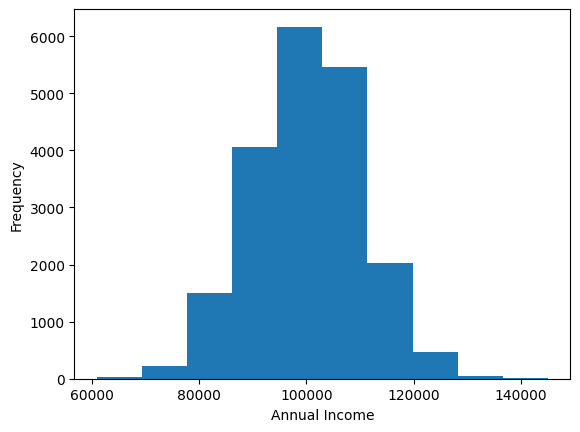

In [10]:
audience_df_encoded.annual_income.plot.hist()
plt.xlabel('Annual Income')
plt.show()

In [11]:
audience_df_encoded['Traditional_segments'] = np.where(audience_df_encoded.annual_income>=120000, 'High Income',
                                                       np.where(audience_df_encoded.annual_income <80000, 'Low Income', 'Moderate Income'))

audience_df_encoded.groupby('Traditional_segments')['annual_income'].describe()

,count,mean,std,min,25%,50%,75%,max
Traditional_segments,,,,,,,,
High Income,523.0,123361.376673,3534.910678,120000.0,121000.0,122000.0,125000.0,145000.0
Low Income,406.0,75534.482759,3463.751353,61000.0,74000.0,76000.0,78000.0,79000.0
Moderate Income,19071.0,99939.174663,8782.130886,80000.0,94000.0,100000.0,106000.0,119000.0


## **Modern Clustering Techniques**

### **K-Means Clustering**

In [12]:
# defining the columns that will be used in clustering
cluster_cols = ['normalized_income', 'ad_score']
audience_df_encoded[cluster_cols].head()

,normalized_income,ad_score
0,0.523810,0.247191
1,0.452381,0.786517
2,0.535714,0.505618
3,0.642857,0.584270
4,0.440476,0.393258


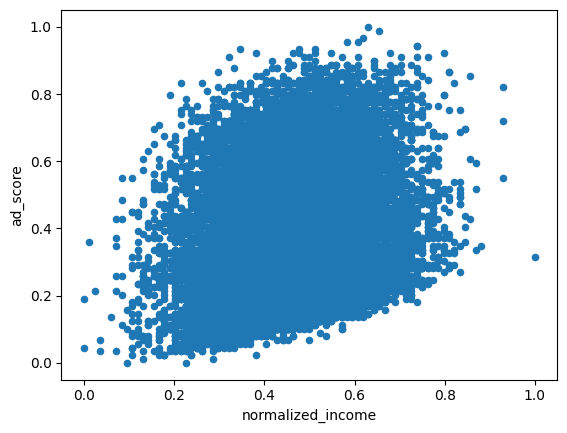

In [13]:
# visualizing the dataset
audience_df_encoded.plot.scatter(x='normalized_income', y='ad_score')
plt.show()

In [14]:
# K-Means modelling
model = KMeans(n_clusters=4, random_state=42)

model.fit(audience_df_encoded[cluster_cols])
audience_df_encoded['Cluster'] = model.predict(audience_df_encoded[cluster_cols])
audience_df_encoded.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
annual_income,105000.0,99000.0,106000.0,115000.0,98000.0
occupation,Health service manager,Tour manager,"Editor, magazine features",Chartered management accountant,Wellsite geologist
no_of_children,0.125,0.25,0.0,0.0,0.125
weekly_avg_viewing_hours,22.8,22.4,16.7,24.2,23.2
education_score,1,4,3,3,2
normalized_income,0.52381,0.452381,0.535714,0.642857,0.440476
norm_viewing_hours,0.581818,0.571429,0.423377,0.618182,0.592208
ad_score,0.247191,0.786517,0.505618,0.58427,0.393258
education_level_Bachelor,0.0,0.0,0.0,0.0,1.0


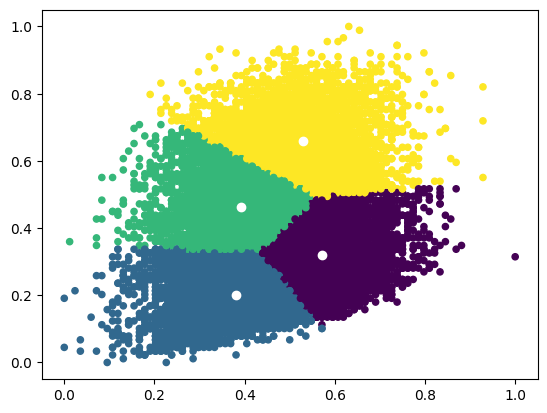

In [15]:
# visualizing the clusters

fig, ax = plt.subplots()

plt.scatter(audience_df_encoded[cluster_cols].iloc[:,0],
            audience_df_encoded[cluster_cols].iloc[:,1],
            c=model.labels_, s=20)
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], color='white')

plt.show()

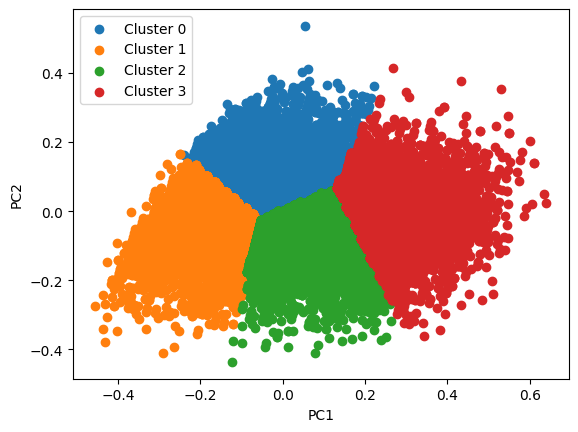

In [16]:
# visualizing with PCA

pca = decomposition.PCA(n_components=2)
pca_res = pca.fit_transform(audience_df_encoded[cluster_cols])
audience_df_encoded['pc1'] = pca_res[:,0]
audience_df_encoded['pc2'] = pca_res[:,1]

for i in range(4):
  temp = audience_df_encoded[audience_df_encoded.Cluster == i]
  plt.scatter(temp.pc1, temp.pc2,
              label="Cluster "+str(i))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

### **Elbow Method**

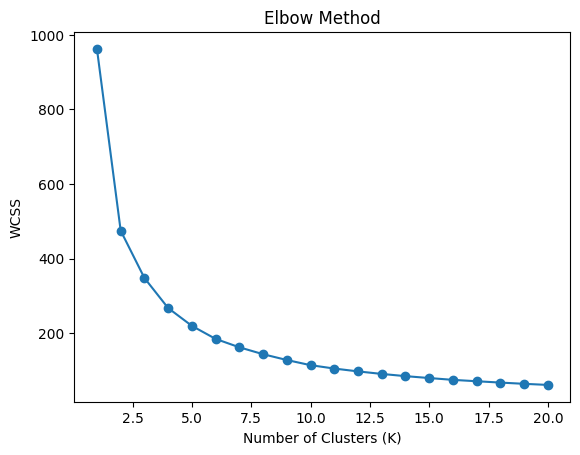

In [17]:
wcss = []
Kmax = 20
for k in range(1, Kmax + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(audience_df_encoded[cluster_cols])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, Kmax + 1), wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


### **Silhouette Method**

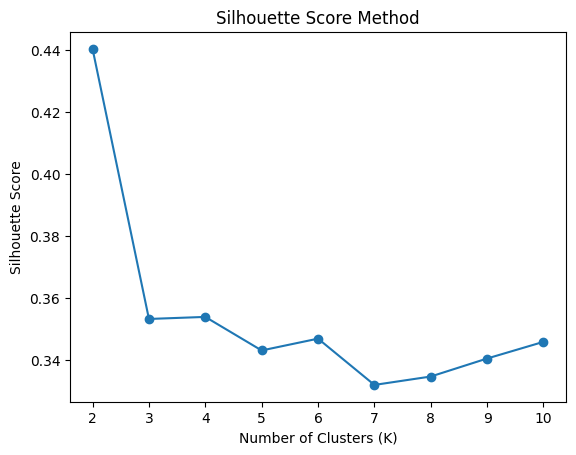

In [18]:
silhouette_scores = []
Kmax = 10
for k in range(2, Kmax + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(audience_df_encoded[cluster_cols])
    score = silhouette_score(audience_df_encoded[cluster_cols], kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, Kmax + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

In [19]:
y_pred = pd.DataFrame(model.labels_, columns = ['Prediction'])

metrics.silhouette_score(audience_df_encoded[cluster_cols], y_pred)

0.35391081303231653

## **Agglomerative Hierarchical Clustering**

In [20]:
n_clusters = 4  # Number of clusters to form
agg_clustering = AgglomerativeClustering(distance_threshold=None,
                                         n_clusters=n_clusters,
                                         affinity='manhattan',
                                         linkage='complete'
                                          )
agg_clustering.fit(audience_df_encoded[cluster_cols])

AgglomerativeClustering(affinity='manhattan', linkage='complete', n_clusters=4)

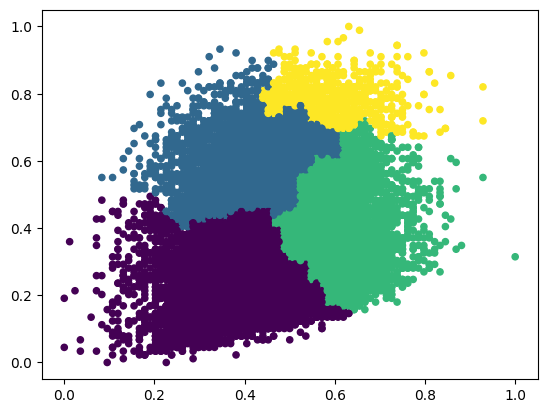

In [21]:
# visualizing the clusters

y_pred = pd.DataFrame(agg_clustering.labels_,columns = ["Prediction"])

plt.scatter(audience_df_encoded[cluster_cols].iloc[:,0],
            audience_df_encoded[cluster_cols].iloc[:,1],
            c=agg_clustering.labels_,
            cmap="viridis",s=20)
plt.show()

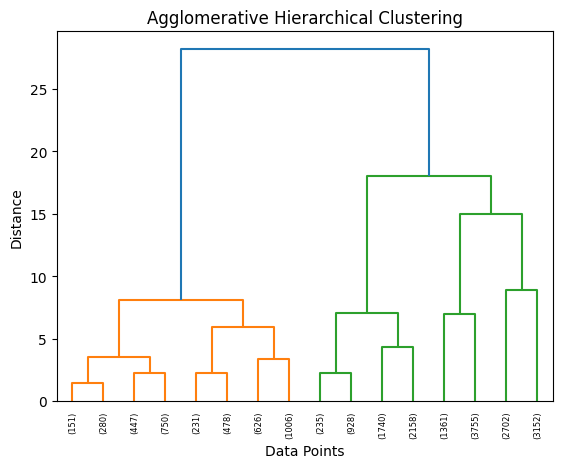

In [22]:
# Compute linkage matrix for the dendrogram
linkage_matrix = linkage(audience_df_encoded[cluster_cols], method='ward')


# Visualizing the hierarchical clustering as a dendrogram
dendrogram(linkage_matrix, p=3, truncate_mode='level')
plt.title('Agglomerative Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=6)
plt.show()

## **Evaluating the K-Means Clustering**

In [24]:
audience_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    20000 non-null  int64  
 1   annual_income                 20000 non-null  float64
 2   occupation                    20000 non-null  object 
 3   no_of_children                20000 non-null  float64
 4   weekly_avg_viewing_hours      20000 non-null  float64
 5   education_score               20000 non-null  int64  
 6   normalized_income             20000 non-null  float64
 7   norm_viewing_hours            20000 non-null  float64
 8   ad_score                      20000 non-null  float64
 9   education_level_Bachelor      20000 non-null  float64
 10  education_level_High School   20000 non-null  float64
 11  education_level_Master        20000 non-null  float64
 12  education_level_PhD           20000 non-null  float64
 13  f

In [25]:
# splitting the dataset into features and target

features = audience_df_encoded[cluster_cols]
target = audience_df_encoded.Cluster

In [27]:
# train and test sets

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size =0.2, random_state=42)

In [28]:
model_eval = KMeans(n_clusters=4)
model_eval.fit(X_train)

KMeans(n_clusters=4)

In [30]:
preds = model_eval.predict(X_test)

In [35]:
# calculating the Davies-Bouldin Index

print("Davies-Bouldin Index:", davies_bouldin_score(X_test, preds))

Davies-Bouldin Index: 0.9005351340874026


In [36]:
# Silhouette Coefficient

print("Silhouette Coefficient:", silhouette_score(X_test, preds))

Silhouette Coefficient: 0.35032206534313837


In [39]:
# Rand Score

print("Adjusted Rand Score:", adjusted_rand_score(y_test, preds))

Adjusted Rand Score: 0.9246955467736437


In [40]:
# Fowlkes Mallows

print("Fowlkes Mallows Score:", fowlkes_mallows_score(y_test, preds))

Fowlkes Mallows Score: 0.9438457865464646
